# Pain in the Net
Replication of *Deeper Image Quality Transfer: Training Low-Memory Neural Networks for 3D Images*


Code by:

Tyler Spears - tas6hh@virginia.edu

Dr. Tom Fletcher

---

Source work:
`S. B. Blumberg, R. Tanno, I. Kokkinos, and D. C. Alexander, “Deeper Image Quality Transfer: Training Low-Memory Neural Networks for 3D Images,” in Medical Image Computing and Computer Assisted Intervention – MICCAI 2018, Cham, 2018, pp. 118–125, doi: 10.1007/978-3-030-00928-1_14.`


## Imports & Environment Setup

In [1]:
# imports
import collections
import dataclasses
from dataclasses import dataclass
import functools
import io
import datetime

import math
import itertools
import os
import pathlib
import copy
import pdb
import random
import subprocess
import sys
import warnings
from pathlib import Path
import typing
from typing import Generator

import ants
import dipy
import dipy.core
import dipy.reconst
import dipy.reconst.dti
import dipy.segment.mask
import dotenv

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Data management libraries.
import nibabel as nib
import nilearn
import nilearn.plotting
import natsort
from natsort import natsorted

# Computation & ML libraries.
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
import torchio
import pytorch_lightning as pl

import skimage
import skimage.feature
import skimage.filters
import skimage.measure
import einops
import einops.layers
import einops.layers.torch

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)
torch.set_printoptions(sci_mode=False, threshold=100, linewidth=88)

/opt/miniconda/envs/pitn/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning:

Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.



In [2]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True);

In [3]:
# Project-specific scripts
# It's easier to import it this way rather than make an entirely new package, due to
# conflicts with local packages and anaconda installations.
# You made me do this, poor python package management!!
if "PROJECT_ROOT" in os.environ:
    src_location = str(Path(os.environ["PROJECT_ROOT"]).resolve())
else:
    src_location = str(Path("../../").resolve())
sys.path.append(src_location)
import src as pitn

In [4]:
# torch setup

# allow for CUDA usage, if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# keep device as the cpu
# device = torch.device('cpu')
print(device)

cuda


In [5]:
# Watermark
%load_ext watermark
%watermark --author "Tyler Spears" --updated --iso8601  --python --machine --iversions --githash
if torch.cuda.is_available():
    print("CUDA Version: ", torch.version.cuda)
else:
    print("CUDA not in use, falling back to CPU")

Author: Tyler Spears

Last updated: 2021-04-23T00:21:41.882392+00:00

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.4.0-72-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: 1cde6e97e9b5cb0572b1e7daeef23a78dba4a342

ants             : 0.2.7
json             : 2.0.9
torchio          : 0.18.31
nibabel          : 3.2.1
numpy            : 1.20.2
einops           : 0.3.0
skimage          : 0.18.1
pytorch_lightning: 1.2.6
dipy             : 1.4.0
seaborn          : 0.11.1
torchvision      : 0.2.2
pandas           : 1.2.3
nilearn          : 0.7.1
matplotlib       : 3.4.1
natsort          : 7.1.1
sys              : 3.8.8 (default, Feb 24 2021, 21:46:12) 
[GCC 7.3.0]
torch            : 1.8.1

CUDA Version:  11.1


## Variables & Definitions Setup

In [6]:
# Set up directories
data_dir = pathlib.Path(os.environ["DATA_DIR"]) / "hcp"
assert data_dir.exists()
write_data_dir = pathlib.Path(os.environ["WRITE_DATA_DIR"]) / "hcp"
assert write_data_dir.exists()
results_dir = pathlib.Path(os.environ["RESULTS_DIR"])
assert results_dir.exists()

In [7]:
# Experiment logging setup
experiment_name = "loss_L1"
ts = datetime.datetime.now().replace(microsecond=0).isoformat()
experiment_name = ts + "_" + experiment_name
experiment_results_dir = results_dir / experiment_name
(experiment_results_dir).mkdir(parents=True, exist_ok=True)
print(experiment_results_dir, "\n", experiment_results_dir.exists())
assert experiment_results_dir.exists()

experiment_results_log = experiment_results_dir / "log.txt"
with open(experiment_results_log, "a+") as f:
    f.write(f"Experiment Name: {experiment_name}\n")
    f.write(f"Timestamp: {ts}\n")

/home/jovyan/work/pitn/results/2021-04-23T00:21:42_loss_L1 
 True


### Global Function & Class Definitions

#### File Reader Objects

In [8]:
# For more clearly designating the return values of a reader function given to
# the `torchio.Image` object.
ReaderOutput = collections.namedtuple("ReaderOutput", ["dwi", "affine"])


def nifti_reader(
    f_dwi,
) -> ReaderOutput:
    """Reader that reads in NIFTI files quickly.

    Meant for use with the `torchio.Image` object and its sub-classes.
    """

    # Load with nibabel first to get the correct affine matrix. See
    # <https://github.com/ANTsX/ANTsPy/issues/52> for why I don't trust antspy for this.
    # This does not require loading the entire NIFTI file into memory.
    affine = nib.load(f_dwi).affine.copy()
    affine = affine.astype(np.float32)
    print(f"Loading NIFTI image: {f_dwi}", flush=True)
    # Load entire image with antspy, then slice and (possibly) downsample that full image.
    # A float32 is the smallest representation that doesn't lose data.
    dwi = ants.image_read(str(f_dwi), pixeltype="float")
    print("\tLoaded NIFTI image", flush=True)

    # Use `torch.tensor()` to explicitly copy the numpy array. May have issues with
    # underlying memory getting garbage collected when using `torch.from_numpy`.
    # <https://pytorch.org/docs/1.8.0/generated/torch.tensor.html#torch.tensor>
    return ReaderOutput(dwi=torch.tensor(dwi.view()), affine=torch.tensor(affine))

#### Data Transformation Objects

In [9]:
# torchio.Transform functions/objects.


class BValSelectionTransform(torchio.SpatialTransform):
    """Sub-selects scans that are within a certain range of bvals.

    Expects:
    - volumes in canonical (RAS+) format with *channels first.*
    - bvecs to be of shape (N, 3), with N being the number of scans/bvals.

    """

    def __init__(self, bval_range: tuple, bval_key, bvec_key, **kwargs):
        super().__init__(**kwargs)

        self.bval_range = bval_range
        self.bval_key = bval_key
        self.bvec_key = bvec_key

    def apply_transform(self, subject: torchio.Subject) -> torchio.Subject:
        print(f"Selecting with bvals: Subject {subject.subj_id}", flush=True)

        for img in self.get_images(subject):
            bvals = img[self.bval_key]
            scans_to_keep = (self.bval_range[0] <= bvals) & (
                bvals <= self.bval_range[-1]
            )
            img[self.bvec_key] = img[self.bvec_key][scans_to_keep, :]
            img.set_data(img.data[scans_to_keep, ...])
            img[self.bval_key] = img[self.bval_key][scans_to_keep]
        print("\tSelected", flush=True)
        return subject


class MeanDownsampleTransform(torchio.SpatialTransform):
    """Mean downsampling transformation.

    sample_extension: the extension of the low-res patch size relative to the full-res
        patch size.

    Ex. sample_extension of 1.5

    Expects volumes in canonical (RAS+) format with *channels first.*
    """

    def __init__(self, downsample_factor: int, spatial_padding: int = 0, **kwargs):
        super().__init__(**kwargs)

        self.downsample_factor = downsample_factor
        self.spatial_padding = spatial_padding

    def apply_transform(self, subject: torchio.Subject) -> torchio.Subject:
        print(f"Downsampling: Subject {subject.subj_id}", flush=True)
        # Get reference to Image objects that have been included for transformation.

        for img in self.get_images(subject):
            img["downsample_factor"] = self.downsample_factor
            if self.downsample_factor == 1:
                continue
            # Determine dimension-specific downsample factors
            img_ndarray = img.data.numpy()
            dim_factors = np.asarray(
                [
                    self.downsample_factor,
                ]
                * img_ndarray.ndim
            )
            # Only spatial dimensions should be downsampled.
            if img.data.ndim > 3:
                # Don't downsample the channels
                dim_factors[0] = 1
                # Or anything else outside of spatial dims.
                dim_factors[4:] = 1

            downsample_vol = skimage.transform.downscale_local_mean(
                img_ndarray, factors=tuple(dim_factors), cval=0
            )
            # Pad with a small number of 0's to account for sampling at the edge of the
            # full-res image.
            # Don't pad dims that were not scaled.
            padding_mask = (dim_factors - 1).astype(bool).astype(int)
            padding = self.spatial_padding * padding_mask
            padding = [(0, p) for p in padding.tolist()]
            downsample_vol = np.pad(downsample_vol, pad_width=padding, mode="constant")

            downsample_vol = torch.from_numpy(
                downsample_vol.astype(img_ndarray.dtype)
            ).to(img.data.dtype)
            img.set_data(downsample_vol)

            scaled_affine = img.affine.copy()
            # Scale the XYZ coordinates on the main diagonal.
            scaled_affine[(0, 1, 2), (0, 1, 2)] = (
                scaled_affine[(0, 1, 2), (0, 1, 2)] * self.downsample_factor
            )
            img.affine = scaled_affine
        print("\tDownsampled", flush=True)
        return subject


class FitDTITransform(torchio.SpatialTransform, torchio.IntensityTransform):
    def __init__(
        self,
        bval_key,
        bvec_key,
        mask_img_key=None,
        fit_method="WLS",
        tensor_model_kwargs=dict(),
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.bval_key = bval_key
        self.bvec_key = bvec_key
        self.mask_img_key = mask_img_key
        self.fit_method = fit_method
        self.tensor_model_kwargs = tensor_model_kwargs

    def apply_transform(self, subject: torchio.Subject) -> torchio.Subject:

        print(f"Fitting to DTI: Subject {subject.subj_id}", flush=True)
        mask_img = subject[self.mask_img_key] if self.mask_img_key is not None else None
        for img in self.get_images(subject):

            gradient_table = dipy.core.gradients.gradient_table_from_bvals_bvecs(
                bvals=img[self.bval_key],
                bvecs=img[self.bvec_key],
            )

            tensor_model = dipy.reconst.dti.TensorModel(
                gradient_table, fit_method=self.fit_method, **self.tensor_model_kwargs
            )
            print(f"\tDWI shape: {img.data.shape}", flush=True)
            # dipy does not like the channels being first, apparently.
            if mask_img is not None:
                dti = tensor_model.fit(
                    np.moveaxis(img.numpy(), 0, -1),
                    mask=mask_img.numpy().squeeze().astype(bool),
                )
            else:
                dti = tensor_model.fit(np.moveaxis(img.numpy(), 0, -1))

            # Pull only the lower-triangular part of the DTI (the non-symmetric
            # coefficients.)
            # Do it all in one line to minimize the time that the DTI's have to be
            # duplicated in memory.
            img.set_data(
                torch.from_numpy(
                    np.moveaxis(dti.lower_triangular().astype(np.float32), -1, 0)
                ).to(img.data)
            )
            print(f"\tDTI shape: {img.shape}", flush=True)
        print(f"\tFitted DTI model: {img.data.shape}", flush=True)

        return subject


class RenameImageTransform(torchio.Transform):
    def __init__(self, name_mapping: dict, **kwargs):
        super().__init__(**kwargs)

        self.name_mapping = name_mapping

    def apply_transform(self, subject: torchio.Subject) -> torchio.Subject:
        for old_name, new_name in self.name_mapping.items():
            tmp = subject[old_name]
            subject.remove_image(old_name)
            subject.add_image(tmp, new_name)
        subject.update_attributes()
        return subject


class ImageToDictTransform(torchio.Transform):
    """Convert a Subject Image to a simple dict item.

    Removes the `include`ed keys from calculation of the Subject's properties, such as
    `spatial_shape`, `spacing`, etc.
    """

    def apply_transform(self, subject: torchio.Subject) -> torchio.Subject:
        for img_name in self.include:

            img_dict = dict(subject[img_name])
            subject.remove_image(img_name)

            subject[img_name] = img_dict

        subject.update_attributes()
        return subject

#### Data Sampling Objects

In [10]:
# Definitions for sampling and loading patches from volumes of different resolutions in
# a `pytorch.utils.data.DataLoader`.


def normalize_batch(patches):
    """Normalize a batch of patches to have mean 0 and variance 1

    Computed over the batches, so means & vars are calculated as:
        (B x C x H x W x D) -> (1 x C x H x W x D)
    """

    mean = torch.mean(patches, dim=0, keepdim=True)
    var = torch.var(patches, dim=0, keepdim=True)
    epsilon = 1e-7

    return (patches - mean) / torch.sqrt(var + epsilon)


def normalize_dti(dti, mean, var):
    """Normalize a 6-channel DTI tensor to have mean 0 and variance 1.

    The normalization occurs according to the dimensionality of the mean and var passed.
        To perform channel-wise normalization, mean and var must have shape
        (C x 1 x 1 x 1)
    """

    epsilon = 1e-5
    return (dti - mean) / torch.sqrt(var + epsilon)


def denormalize_dti(normal_dti, mean, var):
    """Inverse of DTI normalization."""

    epsilon = 1e-5
    return (normal_dti * torch.sqrt(var + epsilon)) + mean


def extract_patch(img, img_spatial_shape, index_ini, patch_size) -> torchio.Image:
    """Draws a patch from img, given an initial index and patch size."""

    # Just take it straight from `torchio.transforms.Copy.apply_transform`
    # and `torchio.sampler.Sampler`!

    shape = np.array(img_spatial_shape, dtype=np.uint16)
    index_ini = np.array(index_ini, dtype=np.uint16)
    patch_size = np.array(patch_size, dtype=np.uint16)
    index_fin = index_ini + patch_size

    crop_ini = index_ini.tolist()
    crop_fin = (shape - index_fin).tolist()
    start = ()
    cropping = sum(zip(crop_ini, crop_fin), start)

    low = cropping[::2]
    high = cropping[1::2]
    initial_idx = low
    final_idx = np.array(img_spatial_shape) - high

    i0, j0, k0 = initial_idx
    i1, j1, k1 = final_idx

    return img[:, i0:i1, j0:j1, k0:k1]


# Custom sampler for sampling multiple volumes of different resolutions.
class MultiresSampler(torchio.LabelSampler):
    """

    source_img_key: Key to the Subject that will fetch the source (a.k.a., the high-res
        or full-res) image.

    low_res_key: Key to the Subject that will fetch the low-res image. This image is
        assumed to be a dictionary with a 'data' key.

    downsample_factor_key: Key to the low-res image dict that gives the downsample
        factor.

    source_spatial_patch_size: 3-tuple of `(W, H, D)` that gives the spatial size of
        patches drawn from the source image.

    low_res_spatial_patch_size: 3-tuple of `(W, H, D)` that gives the spatial size of
        patches drawn from the low-res image.

    subj_keys_to_copy: Tuple of keys to copy from the Subject into the returned sample
        patch(es).
    """

    def __init__(
        self,
        source_img_key,
        low_res_key,
        downsample_factor_key,
        source_spatial_patch_size: tuple,
        low_res_spatial_patch_size: tuple,
        label_name,
        subj_keys_to_copy=tuple(),
        **kwargs,
    ):

        super().__init__(
            patch_size=source_spatial_patch_size, label_name=label_name, **kwargs
        )
        self.source_img_key = source_img_key
        self.low_res_key = low_res_key
        self.downsample_factor_key = downsample_factor_key
        self.subj_keys_to_copy = subj_keys_to_copy
        self.source_spatial_patch_size = source_spatial_patch_size
        self.low_res_spatial_patch_size = low_res_spatial_patch_size

    def __call__(
        self, subject: torchio.Subject, num_patches=None
    ) -> Generator[torchio.Subject, None, None]:

        # Setup copied from the `torchio.WeightedSampler.__call__` function definition.
        subject.check_consistent_space()
        if np.any(self.patch_size > subject.spatial_shape):
            message = (
                f"Patch size {tuple(self.patch_size)} cannot be"
                f" larger than image size {tuple(subject.spatial_shape)}"
            )
            raise RuntimeError(message)
        probability_map = self.get_probability_map(subject)
        probability_map = self.process_probability_map(probability_map, subject)
        cdf = self.get_cumulative_distribution_function(probability_map)

        patches_left = num_patches if num_patches is not None else True
        while patches_left:
            subj_fields_transfer = dict(
                ((k, subject[k]) for k in self.subj_keys_to_copy)
            )

            # Sample an index from the full-res image.
            source_index_ini = self.get_random_index_ini(probability_map, cdf)
            # Create a new subject that only contains patches.
            # Add the patch from the full-res image into the subject.
            source_tensor = extract_patch(
                subject[self.source_img_key].data,
                img_spatial_shape=subject[self.source_img_key].shape[1:],
                index_ini=source_index_ini,
                patch_size=self.source_spatial_patch_size,
            )

            patch_subj = torchio.Subject(
                **(
                    dict(
                        [
                            (
                                self.source_img_key,
                                torchio.ScalarImage(
                                    tensor=source_tensor,
                                    affine=subject[self.source_img_key].affine,
                                ),
                            ),
                            *subj_fields_transfer.items(),
                        ],
                    )
                ),
            )

            # Include the index in the subject.
            patch_subj["index_ini"] = np.array(source_index_ini).astype(int)
            # Crop low-res image and add to the subject.
            lr_index_ini = tuple(
                np.array(source_index_ini).astype(int)
                // subject[self.low_res_key][self.downsample_factor_key]
            )

            lr_patch = extract_patch(
                subject[self.low_res_key]["data"],
                img_spatial_shape=subject[self.low_res_key]["data"].shape[1:],
                index_ini=lr_index_ini,
                patch_size=self.low_res_spatial_patch_size,
            )
            if lr_patch.numel() == 0:
                raise RuntimeError(
                    f"ERROR: Invalid low-res patch: {lr_patch}, {lr_patch.shape} |"
                    + f"Index: {lr_index_ini}"
                )
            # Add a dict to the subject patch, rather than a `torchio.Image`,
            # because the fr and lr patch shapes will be different, and fail
            # `torchio`'s shape consistency checks.)
            lr_patch_dict = dict()
            lr_patch_dict.update(subject[self.low_res_key])
            lr_patch_dict.update({"data": lr_patch})

            patch_subj[self.low_res_key] = lr_patch_dict
            # Return the new patch subject.
            yield patch_subj
            if num_patches is not None:
                patches_left -= 1


class MultiresGridSampler(torchio.GridSampler):
    def __init__(
        self,
        source_img_key,
        low_res_key,
        downsample_factor_key,
        source_spatial_patch_size: tuple,
        low_res_spatial_patch_size: tuple,
        subj_keys_to_copy=tuple(),
        **kwargs,
    ):

        super().__init__(patch_size=source_spatial_patch_size, **kwargs)
        self.source_img_key = source_img_key
        self.low_res_key = low_res_key
        self.downsample_factor_key = downsample_factor_key
        self.subj_keys_to_copy = subj_keys_to_copy
        self.source_spatial_patch_size = source_spatial_patch_size
        self.low_res_spatial_patch_size = low_res_spatial_patch_size

    def __getitem__(self, index):

        location = self.locations[index]
        source_index_ini = location[:3]

        subj_fields_transfer = dict(
            ((k, self.subject[k]) for k in self.subj_keys_to_copy)
        )

        # Create a new subject that only contains patches.
        # Add the patch from the full-res image into the subject.
        source_tensor = extract_patch(
            self.subject[self.source_img_key].data,
            img_spatial_shape=self.subject[self.source_img_key].shape[1:],
            index_ini=source_index_ini,
            patch_size=self.source_spatial_patch_size,
        )

        patch_subj = torchio.Subject(
            **(
                dict(
                    [
                        (
                            self.source_img_key,
                            torchio.ScalarImage(
                                tensor=source_tensor,
                                affine=self.subject[self.source_img_key].affine,
                            ),
                        ),
                        *subj_fields_transfer.items(),
                    ],
                )
            ),
        )

        # Include the index in the subject.
        patch_subj["index_ini"] = np.array(source_index_ini).astype(int)
        patch_subj[torchio.LOCATION] = location
        # Crop low-res image and add to the subject.
        lr_index_ini = tuple(
            np.array(source_index_ini).astype(int)
            // self.subject[self.low_res_key][self.downsample_factor_key]
        )

        lr_patch = extract_patch(
            self.subject[self.low_res_key]["data"],
            img_spatial_shape=self.subject[self.low_res_key]["data"].shape[1:],
            index_ini=lr_index_ini,
            patch_size=self.low_res_spatial_patch_size,
        )
        if lr_patch.numel() == 0:
            raise RuntimeError(
                f"ERROR: Invalid low-res patch: {lr_patch}, {lr_patch.shape} |"
                + f"Index: {lr_index_ini}"
            )
        # Add a dict to the subject patch, rather than a `torchio.Image`,
        # because the fr and lr patch shapes will be different, and fail
        # `torchio`'s shape consistency checks.)
        lr_patch_dict = dict()
        lr_patch_dict.update(self.subject[self.low_res_key])
        lr_patch_dict.update({"data": lr_patch})

        patch_subj[self.low_res_key] = lr_patch_dict

        return patch_subj

In [11]:
# Return type wrapper
MultiresSample = collections.namedtuple("MultiresSample", ("low_res", "full_res"))

# Collate function for the DataLoader to combine multiple samples.
def collate_subj(samples, full_res_key: str, low_res_key: str):
    full_res_stack = torch.stack([subj[full_res_key].data for subj in samples])
    # Assume the low-res data are dicts, not `torchio.Image`'s
    low_res_stack = torch.stack([subj[low_res_key]["data"] for subj in samples])

    return MultiresSample(low_res=low_res_stack, full_res=full_res_stack)

#### Visualization Objects

In [12]:
# Create FA map from DTI's
def fa_map(dti, channels_first=True) -> np.ndarray:
    if torch.is_tensor(dti):
        t = dti.cpu().numpy()
    else:
        t = np.asarray(dti)
    # Reshape to work with dipy.
    if channels_first:
        t = t.transpose(1, 2, 3, 0)

    # Re-create the symmetric DTI's (3x3) from the lower-triangular portion (6).
    t = dipy.reconst.dti.from_lower_triangular(t)
    eigvals, eigvecs = dipy.reconst.dti.decompose_tensor(t)

    fa = dipy.reconst.dti.fractional_anisotropy(eigvals)

    return fa


# Generate FA-weighted diffusion direction map.
def direction_map(dti, channels_first=True) -> np.ndarray:

    if torch.is_tensor(dti):
        t = dti.cpu().numpy()
    else:
        t = np.asarray(dti)
    # Reshape to work with dipy.
    if channels_first:
        t = t.transpose(1, 2, 3, 0)

    # Re-create the symmetric DTI's (3x3) from the lower-triangular portion (6).
    t = dipy.reconst.dti.from_lower_triangular(t)
    eigvals, eigvecs = dipy.reconst.dti.decompose_tensor(t)

    fa = dipy.reconst.dti.fractional_anisotropy(eigvals)
    direction_map = dipy.reconst.dti.color_fa(fa, eigvecs)

    if channels_first:
        return direction_map.transpose(3, 0, 1, 2)

    return direction_map

### Global Parameters

In [13]:
downsample_factor = 2
# Include b=0 shells and b=1000 shells for DTI fitting.
bval_range = (0, 1500)
dti_fit_method = "WLS"

In [14]:
# Patch parameters
batch_size = 64
# 6 channels for the 6 DTI components
channels = 6

# Output patch shapes
h_out = 14
w_out = 14
d_out = 14
# Output shape after shuffling.
output_patch_shape = (channels, h_out, w_out, d_out)
output_spatial_patch_shape = output_patch_shape[1:]
# This is the factor that determines how over-extended the input patch should be
# relative to the size of the full-res patch.
# $low_res_patch_dim = \frac{full_res_patch_dim}{downsample_factor} \times low_res_sample_extension$
# A value of 1 indicates that the input patch dims will be exactly divided by the
# downsample factor. A dilation > 1 increases the "spatial extent" of the input
# patch, providing information outside of the target HR patch.
low_res_sample_extension = 1.57
# Input patch parameters
h_in = round(h_out / (downsample_factor) * low_res_sample_extension)
w_in = round(w_out / (downsample_factor) * low_res_sample_extension)
d_in = round(d_out / (downsample_factor) * low_res_sample_extension)
input_patch_shape = (channels, h_in, w_in, d_in)
input_spatial_patch_shape = input_patch_shape[1:]

# Pre-shuffle output patch sizes.
unshuffled_channels_out = channels * downsample_factor ** 3
# Output before shuffling
unshuffled_output_patch_shape = (unshuffled_channels_out, h_in, w_in, d_in)

In [15]:
with open(experiment_results_log, "a+") as f:
    f.write(f"Downsample Factor: {downsample_factor}\n")
    f.write(f"DTI Fit Method: {dti_fit_method}\n")
    f.write(f"Input Patch Size: {input_patch_shape}\n")
    f.write(f"Output Patch Size: {output_patch_shape}\n")
    f.write(f"Batch Size: {batch_size}\n")

## Data Loading

### Subject ID Selection

In [16]:
# Find data directories for each subject.
subj_dirs: dict = dict()

selected_ids = [
    "397154",
    "224022",
    "140117",
    "751348",
    "894774",
    "156637",
    "227432",
    "303624",
    "185947",
    "810439",
    "753251",
    "644246",
    "141422",
    "135528",
    "103010",
    "700634",
]

## Sub-set the chosen participants for dev and debugging!
selected_ids = random.sample(selected_ids, 10)
warnings.warn(
    "WARNING: Sub-selecting participants for dev and debugging. "
    + f"Subj IDs selected: {selected_ids}"
)
# ### A nested warning! For debugging only.
# warnings.warn("WARNING: Mixing training and testing subjects")
# selected_ids.append(selected_ids[0])
# ###
##

selected_ids = natsorted(list(map(lambda s: int(s), selected_ids)))

for subj_id in selected_ids:
    subj_dirs[subj_id] = data_dir / f"{subj_id}/T1w/Diffusion"
    assert subj_dirs[subj_id].exists()
subj_dirs

<ipython-input-16-a40943793870>:25: UserWarning:




{141422: PosixPath('/mnt/storage/data/pitn/hcp/141422/T1w/Diffusion'),
 156637: PosixPath('/mnt/storage/data/pitn/hcp/156637/T1w/Diffusion'),
 185947: PosixPath('/mnt/storage/data/pitn/hcp/185947/T1w/Diffusion'),
 224022: PosixPath('/mnt/storage/data/pitn/hcp/224022/T1w/Diffusion'),
 227432: PosixPath('/mnt/storage/data/pitn/hcp/227432/T1w/Diffusion'),
 397154: PosixPath('/mnt/storage/data/pitn/hcp/397154/T1w/Diffusion'),
 751348: PosixPath('/mnt/storage/data/pitn/hcp/751348/T1w/Diffusion'),
 753251: PosixPath('/mnt/storage/data/pitn/hcp/753251/T1w/Diffusion'),
 810439: PosixPath('/mnt/storage/data/pitn/hcp/810439/T1w/Diffusion'),
 894774: PosixPath('/mnt/storage/data/pitn/hcp/894774/T1w/Diffusion')}

The 90 scans are taken from the $b=1000 \ s/mm^2$. However, the $b=0$ shells are still required for fitting the diffusion tensors (DTI's), so those will need to be kept, too.

To find those, sub-select with the $0 < bvals < 1500$, or roughly thereabout. A b-val of $995$ or $1005$ still counts as a b=1000.

In [17]:
with open(experiment_results_log, "a+") as f:
    f.write(f"Selected Subjects: {selected_ids}\n")

### Loading and Preprocessing

In [18]:
# Import all image data into a sequence of `torchio.Subject` objects.
subj_data: dict = dict()

for subj_id, subj_dir in subj_dirs.items():
    # Sub-select volumes with only bvals in a certain range. E.x. bvals <= 1100 mm/s^2,
    # a.k.a. only the b=0 and b=1000 shells.
    bvals = torch.as_tensor(np.loadtxt(subj_dir / "bvals").astype(int))
    bvecs = torch.as_tensor(np.loadtxt(subj_dir / "bvecs"))
    # Reshape to be N x 3
    if bvecs.shape[0] == 3:
        bvecs = bvecs.T

    # grad = torchio.ScalarImage(subj_dir/"grad_dev.nii.gz")
    brain_mask = torchio.LabelMap(
        subj_dir / "nodif_brain_mask.nii.gz",
        type=torchio.LABEL,
        channels_last=False,
    )

    # The brain mask is binary.
    brain_mask.set_data(brain_mask.data.bool())

    dwi = torchio.ScalarImage(
        subj_dir / "data.nii.gz",
        type=torchio.INTENSITY,
        bvals=bvals,
        bvecs=bvecs,
        reader=nifti_reader,
        channels_last=True,
    )

    # Padding amount for the downsampled DWI's. Padded to account for low-res patches
    # that extend beyond the corresponding full-res patch; otherwise, patches will be
    # sampled outside the low-res volume.
    lr_spatial_padding = int(
        max(
            0,
            np.ceil(
                low_res_sample_extension * (h_out // downsample_factor)
                - (h_out // downsample_factor)
            )
            + 1,
        )
    )
    channel_mean = dwi.data.mean(dim=(1, 2, 3))
    #     channel_std
    subject_dict = torchio.Subject(subj_id=subj_id, dwi=dwi, brain_mask=brain_mask)

    preproc_transforms = torchio.Compose(
        [
            torchio.transforms.ToCanonical(include=("dwi", "brain_mask"), copy=False),
            BValSelectionTransform(
                bval_range=bval_range,
                bval_key="bvals",
                bvec_key="bvecs",
                include="dwi",
                copy=False,
            ),
            MeanDownsampleTransform(
                downsample_factor,
                spatial_padding=lr_spatial_padding,
                include=("dwi", "brain_mask"),
                keep={"dwi": "fr_dwi", "brain_mask": "fr_brain_mask"},
                copy=False,
            ),
            RenameImageTransform(
                {"dwi": "lr_dwi", "brain_mask": "lr_brain_mask"}, copy=False
            ),
            FitDTITransform(
                "bvals",
                "bvecs",
                "fr_brain_mask",
                fit_method=dti_fit_method,
                include=("fr_dwi"),
                copy=False,
            ),
            FitDTITransform(
                "bvals",
                "bvecs",
                "lr_brain_mask",
                fit_method=dti_fit_method,
                include=("lr_dwi"),
                copy=False,
            ),
            RenameImageTransform({"fr_dwi": "fr_dti", "lr_dwi": "lr_dti"}, copy=False),
            ImageToDictTransform(include=("lr_dti", "lr_brain_mask"), copy=False),
        ]
    )
    # Normalize DTI's to have mean 0 and variance 1.
    preproced_subj = preproc_transforms(subject_dict)
    # Store subject-and-channel-wise means and vars in order to reverse the normalization
    # for the final visualization/output.
    fr_mask = preproced_subj.fr_brain_mask.tensor

    preproced_subj["channel_means"] = (
        (preproced_subj.fr_dti.tensor * fr_mask)
        .mean(dim=(1, 2, 3), keepdim=True)
        .cpu()
        .numpy()
    )
    preproced_subj["channel_var"] = (
        (preproced_subj.fr_dti.tensor * fr_mask)
        .var(dim=(1, 2, 3), keepdim=True)
        .cpu()
        .numpy()
    )

    preproced_subj["fr_dti"].set_data(
        normalize_dti(
            preproced_subj["fr_dti"].data,
            torch.as_tensor(preproced_subj["channel_means"]),
            torch.as_tensor(preproced_subj["channel_var"]),
        )
    )
    preproced_subj["lr_dti"]["data"] = normalize_dti(
        preproced_subj["lr_dti"]["data"],
        torch.as_tensor(preproced_subj["channel_means"]),
        torch.as_tensor(preproced_subj["channel_var"]),
    )
    subj_data[subj_id] = preproced_subj


print("===Data Loaded & Transformed===")

Loading NIFTI image: /mnt/storage/data/pitn/hcp/141422/T1w/Diffusion/data.nii.gz
	Loaded NIFTI image
Selecting with bvals: Subject 141422
	Selected
Downsampling: Subject 141422
	Downsampled
Fitting to DTI: Subject 141422
	DWI shape: torch.Size([108, 145, 174, 145])
	DTI shape: (6, 145, 174, 145)
	Fitted DTI model: torch.Size([6, 145, 174, 145])
Fitting to DTI: Subject 141422
	DWI shape: torch.Size([108, 78, 92, 78])
	DTI shape: (6, 78, 92, 78)
	Fitted DTI model: torch.Size([6, 78, 92, 78])
Loading NIFTI image: /mnt/storage/data/pitn/hcp/156637/T1w/Diffusion/data.nii.gz
	Loaded NIFTI image
Selecting with bvals: Subject 156637
	Selected
Downsampling: Subject 156637
	Downsampled
Fitting to DTI: Subject 156637
	DWI shape: torch.Size([108, 145, 174, 145])
	DTI shape: (6, 145, 174, 145)
	Fitted DTI model: torch.Size([6, 145, 174, 145])
Fitting to DTI: Subject 156637
	DWI shape: torch.Size([108, 78, 92, 78])
	DTI shape: (6, 78, 92, 78)
	Fitted DTI model: torch.Size([6, 78, 92, 78])
Loading NI

In [19]:
subj_dataset = torchio.SubjectsDataset(list(subj_data.values()), load_getitem=False)

## Model Training

### Set Up Patch-Based Data Loaders

In [20]:
# Data train/validation/test split
test_percent = 0.2
# test_percent = 0.5
train_percent = 1 - test_percent
# val_percent = 0.1

num_subjs = len(subj_dataset)
num_test_subjs = int(np.ceil(num_subjs * test_percent))
num_train_subjs = num_subjs - num_test_subjs
subj_list = subj_dataset.dry_iter()
# Randomly shuffle the list of subjects, then choose the first `num_test_subjs` subjects
# for testing.
random.shuffle(subj_list)

# Create partial function to collect list of samples and form a tuple of tensors.
collate_fn = functools.partial(
    collate_subj, full_res_key="fr_dti", low_res_key="lr_dti"
)

test_dataset = torchio.SubjectsDataset(subj_list[:num_test_subjs], load_getitem=False)
# Choose the remaining for training/validation.
# If only 1 subject is available, assume this is a debugging run.
if num_subjs == 1 and num_train_subjs == 0:
    print("DEBUG: Only 1 subject with no training subjects, mixing train and test set")
    subj_list = subj_list[:]
    num_train_subjs = num_test_subjs
else:
    subj_list = subj_list[num_test_subjs:]

train_dataset = torchio.SubjectsDataset(subj_list, load_getitem=False)

# Training patch sampler, random across all patches of all volumes.
train_sampler = MultiresSampler(
    source_img_key="fr_dti",
    low_res_key="lr_dti",
    downsample_factor_key="downsample_factor",
    label_name="fr_brain_mask",
    source_spatial_patch_size=output_spatial_patch_shape,
    low_res_spatial_patch_size=input_spatial_patch_shape,
    label_probabilities={0: 0, 1: 1},
)

patches_per_subj = 8000
queue_max_length = patches_per_subj * num_train_subjs

# Set up a torchio.Queue to act as a sampler proxy for the torch DataLoader
train_queue = torchio.Queue(
    train_dataset,
    max_length=queue_max_length,
    samples_per_volume=patches_per_subj,
    sampler=train_sampler,
    shuffle_patches=True,
    shuffle_subjects=True,
    num_workers=0,
    #     verbose=True,
)

train_loader = torch.utils.data.DataLoader(
    train_queue,
    batch_size=batch_size,
    collate_fn=collate_fn,
    pin_memory=True,
)

# Set up testing objects.
# Calculate the patch overlap needed for ~50% of the patch volume overlapping (which is
# not the same as dividing each dimension by 2).
input_vol_half_overlap = int(
    np.floor(np.power(np.prod(input_spatial_patch_shape) / 2, 1 / 3))
)
# torchio requires an even-numbered overlap.
if input_vol_half_overlap % 2 == 1:
    input_vol_half_overlap += 1
input_vol_half_overlap = np.repeat(input_vol_half_overlap, 3)

# Repeat for the output.
output_vol_half_overlap = np.floor(
    np.power(np.prod(output_spatial_patch_shape) / 2, 1 / 3)
).astype(int)
# torchio requires an even-numbered overlap.
if output_vol_half_overlap % 2 == 1:
    output_vol_half_overlap += 1
output_vol_half_overlap = np.repeat(output_vol_half_overlap, 3)

# Test samplers
test_samplers = list()
for subj in test_dataset.dry_iter():
    test_samplers.append(
        MultiresGridSampler(
            subject=subj,
            source_img_key="fr_dti",
            low_res_key="lr_dti",
            downsample_factor_key="downsample_factor",
            source_spatial_patch_size=output_spatial_patch_shape,
            low_res_spatial_patch_size=input_spatial_patch_shape,
            patch_overlap=output_vol_half_overlap,
        )
    )

concat_test_dataset = torch.utils.data.ConcatDataset(test_samplers)
test_loader = torch.utils.data.DataLoader(
    concat_test_dataset, batch_size=batch_size, collate_fn=collate_fn, pin_memory=True
)


print("Test subject(s) IDs: ", [s.subj_id for s in test_dataset.dry_iter()])
print("Training subject(s) IDs: ", [s.subj_id for s in train_dataset.dry_iter()])

Test subject(s) IDs:  [894774, 810439]
Training subject(s) IDs:  [753251, 185947, 397154, 751348, 141422, 156637, 227432, 224022]


In [21]:
with open(experiment_results_log, "a+") as f:
    f.write(f"Training Set Subjects: {[s.subj_id for s in test_dataset.dry_iter()]}\n")
    f.write(f"Test Set Subjects: {[s.subj_id for s in train_dataset.dry_iter()]}\n")

### Model Definition

In [22]:
# Shuffle operation as a function.
def espcn_shuffle(x, channels):
    """Implements final-layer shuffle operation from ESPCN.

    x: 4D or 5D Tensor. Expects a shape of $C \times H \times W \times D$, or batched
        with a shape of $B \times C \times H \times W \times D$.

    channels: Integer giving the number of channels for the shuffled output.
    """
    batched = True if x.ndim == 5 else False

    if batched:
        downsample_factor = int(np.power(x.shape[1] / channels, 1 / 3))
        y = einops.rearrange(
            x,
            "b (c r1 r2 r3) h w d -> b c (h r1) (w r2) (d r3)",
            c=channels,
            r1=downsample_factor,
            r2=downsample_factor,
            r3=downsample_factor,
        )
    else:
        downsample_factor = int(np.power(x.shape[0] / channels, 1 / 3))
        y = einops.rearrange(
            x,
            "(c r1 r2 r3) h w d -> c (h r1) (w r2) (d r3)",
            c=channels,
            r1=downsample_factor,
            r2=downsample_factor,
            r3=downsample_factor,
        )

    return y

In [23]:
# Basic conv net definition.
class ThreeConv(torch.nn.Module):
    """Basic three-layer 3D conv network for DIQT."""

    def __init__(self, channels: int, downsample_factor: int):
        super().__init__()
        self.channels = channels
        self.downsample_factor = downsample_factor

        # Set up Conv layers.
        self.conv1 = torch.nn.Conv3d(self.channels, 50, kernel_size=(3, 3, 3))
        self.conv2 = torch.nn.Conv3d(50, 100, kernel_size=(1, 1, 1))
        self.conv3 = torch.nn.Conv3d(
            100, self.channels * (self.downsample_factor ** 3), kernel_size=(3, 3, 3)
        )
        self.output_shuffle = einops.layers.torch.Rearrange(
            "b (c r1 r2 r3) h w d -> b c (h r1) (w r2) (d r3)",
            c=self.channels,
            r1=self.downsample_factor,
            r2=self.downsample_factor,
            r3=self.downsample_factor,
        )

    def forward(self, x):
        #         breakpoint()
        y_hat = self.conv1(x)
        y_hat = F.relu(y_hat)
        y_hat = self.conv2(y_hat)
        y_hat = F.relu(y_hat)
        y_hat = self.conv3(y_hat)

        # Shuffle output.
        y_hat = self.output_shuffle(y_hat)
        return y_hat

In [24]:
# Full pytorch-lightning module for contained training, validation, and testing.
class DIQTSystem(pl.LightningModule):
    def __init__(self, channels, downsample_factor):
        super().__init__()

        self._channels = channels
        self._downsample_factor = downsample_factor

        # Parameters
        # Network parameters
        self.net = ThreeConv(self._channels, self._downsample_factor)

        ## Training parameters
        self._lr = 10e-3
        self._betas = (0.9, 0.999)
        #         self._loss_fn = torch.nn.MSELoss(reduction="mean")
        #         self._loss_fn = torch.nn.MSELoss(reduction="sum")
        self._loss_fn = torch.nn.L1Loss(reduction="mean")
        #         self._loss_fn = lambda y_hat, y: torch.sqrt(
        #             F.mse_loss(y_hat, y, reduction="mean")
        #         )

        # My own dinky logging object.
        self.plain_log = {"train_loss": list(), "val_loss": list(), "test_loss": list()}

    def forward(self, x):
        y = self.net(x)
        return y

    def training_step(self, batch, batch_idx):
        x, y = batch
        #         x = normalize_batch(x)
        #         y = normalize_batch(y)
        y_pred = self.net(x)
        #         y_pred = normalize_batch(y_pred)
        loss = self._loss_fn(y_pred, y)
        self.log("train_loss", loss)
        self.plain_log["train_loss"].append(float(loss.cpu()))
        return loss

    #     def validation_step(self, batch, batch_idx):
    #         pass

    def test_step(self, batch, batch_idx):

        x, y = batch
        #         x = normalize_batch(x)
        #         y = normalize_batch(y)
        y_pred = self.net(x)
        # Normalize the prediction, to make sure the RMSE is scaled correctly.
        #         y_pred = normalize_batch(y_pred)
        test_loss = torch.sqrt(F.mse_loss(y_pred, y))
        self.log("test_loss", test_loss)
        self.plain_log["test_loss"].append(float(test_loss.cpu()))

        return test_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.net.parameters(), lr=self._lr, betas=self._betas
        )
        return optimizer

### Training

In [25]:
# Training parameters
max_epochs = 40

In [ ]:
model = DIQTSystem(channels=channels, downsample_factor=downsample_factor)
# Create trainer object. Note: `automatic_optimization` needs to be set to `False` when
# manually performing backprop. See
# <https://colab.research.google.com/drive/1nGtvBFirIvtNQdppe2xBes6aJnZMjvl8?usp=sharing>
trainer = pl.Trainer(gpus=1, max_epochs=max_epochs, progress_bar_refresh_rate=5)

trainer.fit(model, train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type      | Params
---------------------------------------
0 | net      | ThreeConv | 142 K 
1 | _loss_fn | L1Loss    | 0     
---------------------------------------
142 K     Trainable params
0         Non-trainable params
142 K     Total params
0.572     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [29]:
train_loss_name = "Mean L1 Loss"

0.035177414493635296
0.04106124797327952 0.0008759478489787894 0.8954424262046814


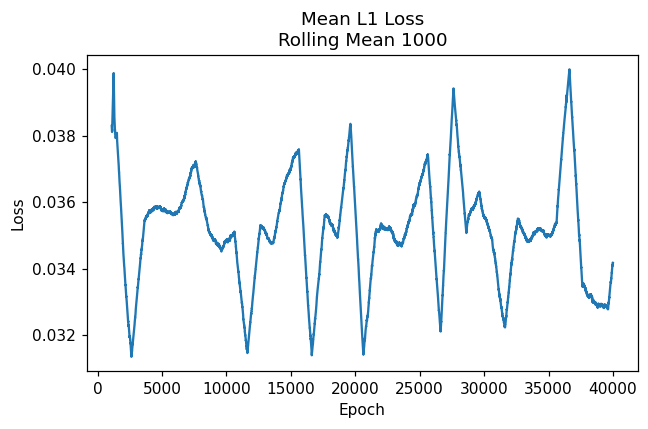

In [30]:
# Plot rolling average window of training loss values.
plt.figure(dpi=110)
window = 1000
rolling_mean = (
    np.convolve(model.plain_log["train_loss"], np.ones(window), "valid") / window
)
rolling_start = 100
plt.plot(
    np.arange(
        window + rolling_start,
        window + rolling_start + len(rolling_mean[rolling_start:]),
    ),
    rolling_mean[rolling_start:],
)
plt.title(train_loss_name + f"\nRolling Mean {window}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.ylim(0, 1)
print(np.median(rolling_mean))
print(
    np.mean(model.plain_log["train_loss"][: window + rolling_start]),
    np.var(model.plain_log["train_loss"][: window + rolling_start]),
    np.max(model.plain_log["train_loss"][: window + rolling_start]),
)

plt.savefig(experiment_results_dir / "train_loss.png")

In [31]:
len(model.plain_log["train_loss"])

40000

In [32]:
with open(experiment_results_log, "a+") as f:
    f.write(f"Model overview: {model}\n")
    f.write(f"Training loss function: {train_loss_name}\n")
    f.write(f'Training loss: \n\t {model.plain_log["train_loss"]} \n')

## Model Evaluation

### Testing

In [36]:
trainer.test(test_dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/miniconda/envs/pitn/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning:

The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.07066256552934647}
--------------------------------------------------------------------------------


[{'test_loss': 0.07066256552934647}]

In [37]:
test_loss_name = "RMSE"

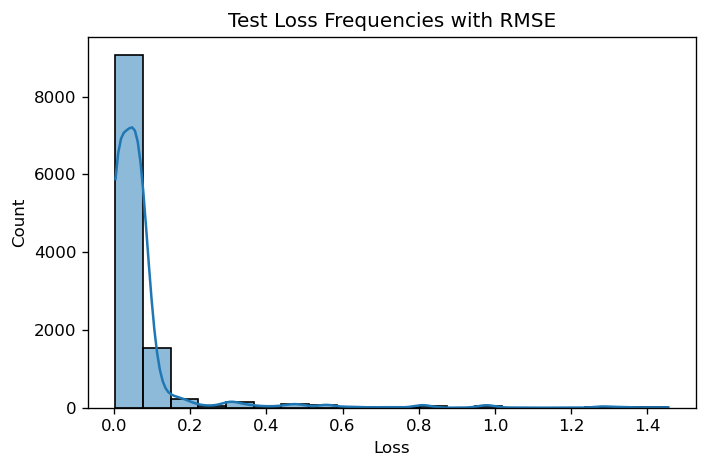

In [38]:
plt.figure(dpi=120)
sns.histplot(np.asarray(model.plain_log["test_loss"]), kde=True, bins=20)
plt.xlabel("Loss")
plt.title(f"Test Loss Frequencies with {test_loss_name}")
plt.savefig(experiment_results_dir / "test_loss.png")

In [39]:
with open(experiment_results_log, "a+") as f:
    f.write(f"Test loss function: {test_loss_name}\n")
    f.write(f'Testing loss: \n\t {model.plain_log["test_loss"]} \n')

In [40]:
np.asarray(model.plain_log["test_loss"]).max()

1.4554086923599243

### Visualization

In [41]:
# Create full 3D volume of full-res ground truth, low-res downsample, and high-res
# inferences.
@dataclass
class SubjResult:
    subj_id: int
    full_res: torch.Tensor
    low_res: torch.Tensor
    full_res_predicted: torch.Tensor


test_vol_results = list()

with torch.no_grad():

    for subj in test_dataset.dry_iter():

        # Create a grid sampler for this subject.
        subj_sampler = MultiresGridSampler(
            subject=subj,
            source_img_key="fr_dti",
            low_res_key="lr_dti",
            downsample_factor_key="downsample_factor",
            source_spatial_patch_size=output_spatial_patch_shape,
            low_res_spatial_patch_size=input_spatial_patch_shape,
            patch_overlap=output_vol_half_overlap,
        )

        loader = torch.utils.data.DataLoader(
            subj_sampler, batch_size=256, pin_memory=True
        )
        aggregator = torchio.GridAggregator(subj_sampler, "average")

        # Iterate over all batches of patches.
        for batch in loader:

            x = batch["lr_dti"]["data"]
            #             x = normalize_batch(x)
            #             y = batch['fr_dti']['data']
            # Locations are in reference to the full-res groud truth.
            locations = batch["location"]
            predictions = model(x.to(model.device))
            #             predictions = normalize_batch(predictions)
            aggregator.add_batch(predictions.cpu(), locations)

        # Collect the full-res ground truth, the low-res input, and the high-res
        # prediction (aggregated) into one container object.
        subj_means = torch.as_tensor(subj["channel_means"])
        subj_vars = torch.as_tensor(subj["channel_var"])
        subj_result = SubjResult(
            subj_id=subj["subj_id"],
            full_res=denormalize_dti(
                subj["fr_dti"].tensor,
                subj_means.to(subj["fr_dti"].tensor),
                subj_vars.to(subj["fr_dti"].tensor),
            ),
            low_res=denormalize_dti(
                subj["lr_dti"]["data"],
                subj_means.to(subj["lr_dti"]["data"]),
                subj_vars.to(subj["lr_dti"]["data"]),
            ),
            full_res_predicted=denormalize_dti(
                aggregator.get_output_tensor(), subj_means, subj_vars
            ),
        )

        test_vol_results.append(subj_result)

In [108]:
slice_idx = (slice(None, None, None), slice(None, None, None), 68)
vis_subj_idx = 1

In [43]:
# Generate FA-weighted diffusion direction map.
tensor_key = "full_res_predicted"
pred_dir_map = direction_map(
    test_vol_results[vis_subj_idx].__getattribute__(tensor_key).data.cpu().numpy()
)
# Set channels last for matplotlib
pred_dir_map = pred_dir_map.transpose(1, 2, 3, 0)

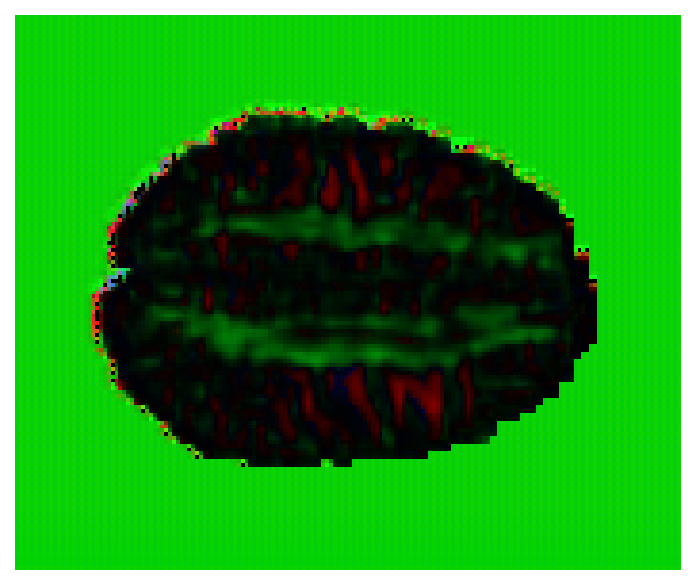

In [57]:
plt.figure(dpi=150)
plt.imshow(pred_dir_map[slice_idx])
plt.axis("off")
plt.savefig(experiment_results_dir / "pred_dir_map_sample.png");

In [45]:
# Generate FA-weighted diffusion direction map.
tensor_key = "full_res"
fr_dir_map = direction_map(
    test_vol_results[vis_subj_idx].__getattribute__(tensor_key).data.cpu().numpy()
)
# Set channels last for matplotlib
fr_dir_map = fr_dir_map.transpose(1, 2, 3, 0)

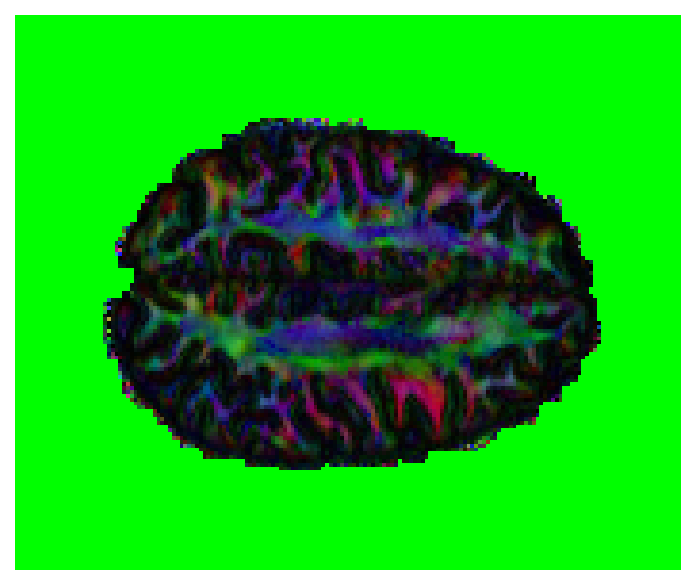

In [58]:
plt.figure(dpi=150)
plt.imshow(fr_dir_map[slice_idx])
# plt.colorbar()
plt.axis("off")
plt.savefig(experiment_results_dir / "ground_truth_dir_map_sample.png")

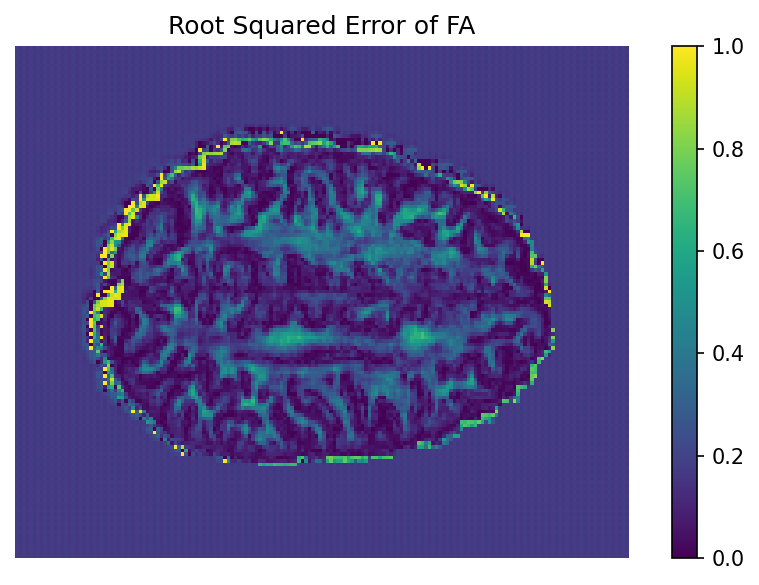

In [59]:
plt.figure(dpi=150)
pred_fa = fa_map(test_vol_results[vis_subj_idx].full_res_predicted.data.cpu().numpy())
fr_fa = fa_map(test_vol_results[vis_subj_idx].full_res.data.cpu().numpy())

plt.title("Root Squared Error of FA")
plt.imshow(np.sqrt((pred_fa[slice_idx] - fr_fa[slice_idx]) ** 2))
plt.colorbar()
plt.axis("off")
plt.savefig(experiment_results_dir / "RMSE_FA_sample.png")

In [85]:
# Display all 6 DTIs for ground truth, predicted, and root squared error

channel_names = ["Dxx", "Dxy", "Dyy", "Dxz", "Dyz", "Dzz"]
dti_names = ["Full-Res", "Predicted", "Root Squared Error"]
# cmaps = ["Reds", "Greys", "Greens", "Purples", "Greys", "Blues", ]

dtis = [
    test_vol_results[vis_subj_idx]
    .full_res.data[(slice(None), *slice_idx)]
    .cpu()
    .numpy(),
    test_vol_results[vis_subj_idx]
    .full_res_predicted[(slice(None), *slice_idx)]
    .cpu()
    .numpy(),
]

# Add root squared error
dtis.append(np.sqrt((dtis[0] - dtis[1]) ** 2))

nrows = len(dtis)
ncols = len(channel_names)

fig = plt.figure(figsize=(12, 6), dpi=140)

grid = mpl.gridspec.GridSpec(
    nrows,
    ncols,
    figure=fig,
    hspace=0.05,
    wspace=0.05,
)

for i_row in range(nrows):
    dti = dtis[i_row]

    for j_col in range(ncols):
        ax = fig.add_subplot(grid[i_row, j_col])
        ax.imshow(np.rot90(dti[j_col]), cmap='jet', interpolation=None)
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(dti_names[i_row])
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(channel_names[j_col])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

plt.savefig(experiment_results_dir / "DTI_channel_sample_nonnormal.png")

torch.Size([6, 145, 174, 145])

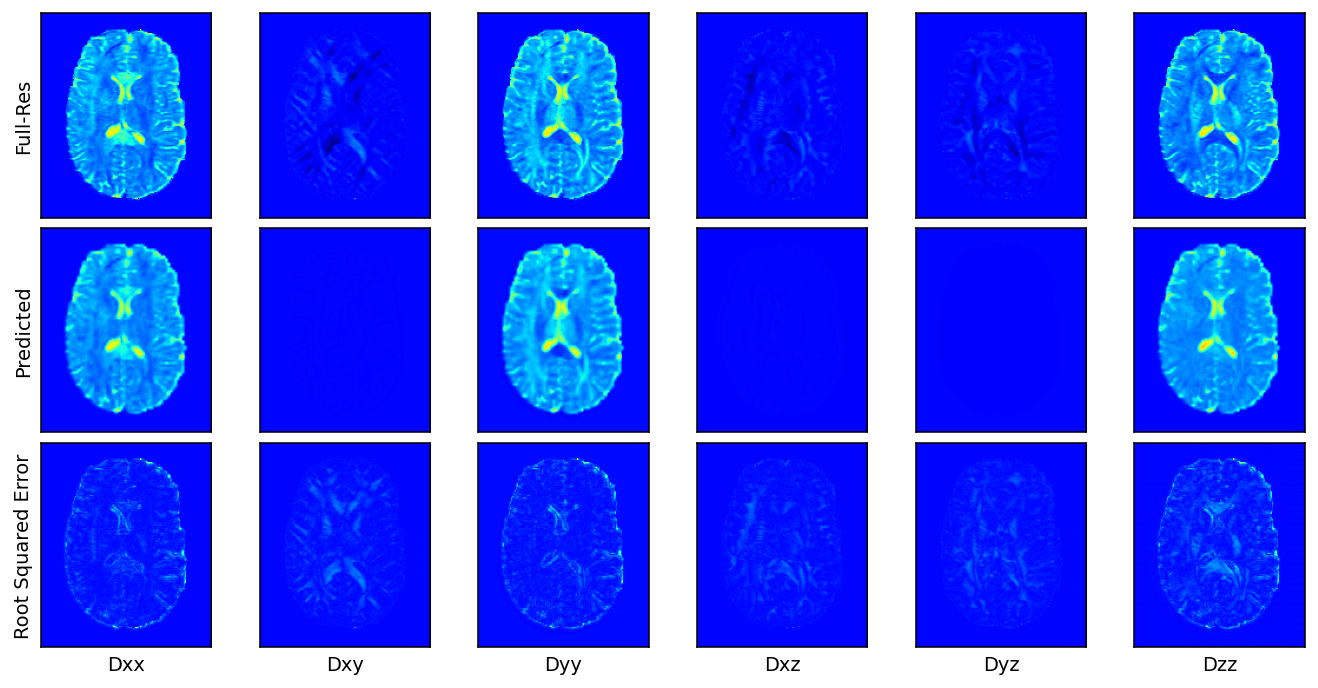

In [160]:
# Display all 6 DTIs for ground truth, predicted, and root squared error

channel_names = ["Dxx", "Dxy", "Dyy", "Dxz", "Dyz", "Dzz"]
dti_names = ["Full-Res", "Predicted", "Root Squared Error"]
# cmaps = ["Reds", "Greys", "Greens", "Purples", "Greys", "Blues", ]

dtis = [
    test_vol_results[vis_subj_idx]
    .full_res.data[(slice(None), *slice_idx)]
    .cpu()
    .numpy(),
    test_vol_results[vis_subj_idx]
    .full_res_predicted[(slice(None), *slice_idx)]
    .cpu()
    .numpy(),
]

# Add root squared error
dtis.append(np.sqrt((dtis[0] - dtis[1]) ** 2))

max_dti = max([dti.max() for dti in dtis])
min_dti = min([dti.min() for dti in dtis])

nrows = len(dtis)
ncols = len(channel_names)

fig = plt.figure(figsize=(12, 6), dpi=140)

grid = mpl.gridspec.GridSpec(
    nrows,
    ncols,
    figure=fig,
    hspace=0.05,
    wspace=0.05,
)

for i_row in range(nrows):
    dti = dtis[i_row]

    for j_col in range(ncols):
        ax = fig.add_subplot(grid[i_row, j_col])
        ax.imshow(np.rot90(dti[j_col]), cmap='jet', interpolation=None, vmin=min_dti, vmax=max_dti)
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(dti_names[i_row])
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(channel_names[j_col])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

plt.savefig(experiment_results_dir / "DTI_channel_sample_normalized.png")

-0.0007151827

In [ ]:
# tensor_key = "full_res_predicted"
# for result in test_vol_results:
#     np.save(
#         results_dir / f"subj_{result.subj_id}_full_res_predicted",
#         result.__getattribute__(tensor_key).data.cpu().numpy(),
#     )